In [1]:
import optuna
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# import sys
# import os

# # Go two levels up from this file to reach project root
# current_dir = os.path.dirname(os.path.abspath(__file__))
# project_root = os.path.abspath(os.path.join(current_dir, ".."))
# sys.path.append(project_root)
import os
current_dir = os.getcwd()
import sys
sys.path.append(r"E:\ITSolera\Health_monitoring_system\Health-Monitoring")

from Models.models import HybridModel


# from Models.models import HybridModel  # adjust path if needed


In [4]:
data = np.load("E:\ITSolera\Health_monitoring_system\Health-Monitoring\Data\Processed\Training_Prepared_Data\V2_dataset.npz")
X_value = data["X"]
y_value =data["y"]

#convert to tensors
X = torch.tensor(X_value, dtype=torch.float32)
y = torch.tensor(y_value, dtype=torch.long)

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_20364\466858000.py:1: SyntaxWarning: invalid escape sequence '\I'
  data = np.load("E:\ITSolera\Health_monitoring_system\Health-Monitoring\Data\Processed\Training_Prepared_Data\V2_dataset.npz")


In [5]:
# EarlyStopping helper
# =====================
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [6]:
# =====================
# Optuna objective
# =====================
def objective(trial):
    cnn_channels = trial.suggest_categorical("cnn_channels", [16, 32, 64])
    lstm_hidden = trial.suggest_categorical("lstm_hidden", [32, 64, 128])
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    k_folds = 3
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fold_accuracies = []
    for train_idx, val_idx in skf.split(X, y):
        train_loader = DataLoader(TensorDataset(X[train_idx], y[train_idx]), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X[val_idx], y[val_idx]), batch_size=batch_size, shuffle=False)

        model = HybridModel(
            input_channels=X.shape[2],
            cnn_channels=cnn_channels,
            lstm_hidden=lstm_hidden,
            lstm_layers=lstm_layers,
            num_classes=len(torch.unique(y))
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        early_stopper = EarlyStopping(patience=3)

        for epoch in range(30):  # max epochs
            # --- Training ---
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

            # --- Validation ---
            model.eval()
            val_loss, y_true, y_pred = 0.0, [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    outputs = model(xb)
                    val_loss += criterion(outputs, yb).item()
                    preds = torch.argmax(outputs, dim=1)
                    y_true.extend(yb.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            val_loss /= len(val_loader)
            early_stopper(val_loss)
            if early_stopper.early_stop:
                break

        acc = accuracy_score(y_true, y_pred)
        fold_accuracies.append(acc)

    return np.mean(fold_accuracies)

In [7]:
# =====================
# Run Optuna tuning
# =====================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Params:", best_params)
print("Best CV Accuracy:", study.best_value)

[I 2025-08-16 12:05:11,580] A new study created in memory with name: no-name-81c5ea8c-dcf6-4dcd-a265-bd6955d22137
C:\Users\PMLS\AppData\Local\Temp\ipykernel_20364\4020704571.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-08-16 12:05:36,886] Trial 0 finished with value: 0.8783686627006819 and parameters: {'cnn_channels': 16, 'lstm_hidden': 32, 'lstm_layers': 1, 'lr': 0.0040516293454200105, 'batch_size': 16}. Best is trial 0 with value: 0.8783686627006819.
C:\Users\PMLS\AppData\Local\Temp\ipykernel_20364\4020704571.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2

Best Params: {'cnn_channels': 32, 'lstm_hidden': 32, 'lstm_layers': 2, 'lr': 0.00017366050532753203, 'batch_size': 16}
Best CV Accuracy: 0.9604505037737048


In [ ]:
# =====================
# Final training with best params
# =====================
import matplotlib.pyplot as plt
import seaborn as sns

def final_training(X_train, y_train, X_val, y_val, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HybridModel(
        input_channels=X_train.shape[2],
        cnn_channels=params["cnn_channels"],
        lstm_hidden=params["lstm_hidden"],
        lstm_layers=params["lstm_layers"],
        num_classes=len(torch.unique(y_train))
    ).to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params["batch_size"], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])
    early_stopper = EarlyStopping(patience=5)

    for epoch in range(50):
        # Train
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss, y_true, y_pred = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item()
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= len(val_loader)
        acc = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}, Val Acc = {acc:.4f}")
        
        # plt.figure(figsize=(8,5))
        # plt.plot(loss, label="Train Loss")
        # plt.plot(val_loss, label="Val Loss")
        # plt.xlabel("Epoch")
        # plt.ylabel("Loss")
        # plt.title("Training & Validation Loss")
        # plt.legend()
        # plt.show()
        
        

        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    return model


In [9]:
from sklearn.model_selection import train_test_split

X_train , X_val ,y_train, y_val = train_test_split(X,y , test_size = 0.2 , stratify = y , random_state = 42)

final_model = final_training(X, y, X_val, y_val, best_params)
print(f"Final_model_training with optimized hyperparameters :  {final_model}")

Epoch 1: Val Loss = 0.8642, Val Acc = 0.8060
Epoch 2: Val Loss = 0.4060, Val Acc = 0.8731
Epoch 3: Val Loss = 0.3141, Val Acc = 0.8731
Epoch 4: Val Loss = 0.2494, Val Acc = 0.9142
Epoch 5: Val Loss = 0.1722, Val Acc = 0.9478
Epoch 6: Val Loss = 0.1410, Val Acc = 0.9664
Epoch 7: Val Loss = 0.1608, Val Acc = 0.9291
Epoch 8: Val Loss = 0.1237, Val Acc = 0.9552
Epoch 9: Val Loss = 0.1093, Val Acc = 0.9627
Epoch 10: Val Loss = 0.0873, Val Acc = 0.9813
Epoch 11: Val Loss = 0.1223, Val Acc = 0.9552
Epoch 12: Val Loss = 0.2030, Val Acc = 0.9328
Epoch 13: Val Loss = 0.0879, Val Acc = 0.9813
Epoch 14: Val Loss = 0.0681, Val Acc = 0.9813
Epoch 15: Val Loss = 0.1420, Val Acc = 0.9366
Epoch 16: Val Loss = 0.0662, Val Acc = 0.9851
Epoch 17: Val Loss = 0.0673, Val Acc = 0.9813
Epoch 18: Val Loss = 0.0962, Val Acc = 0.9627
Epoch 19: Val Loss = 0.1487, Val Acc = 0.9478
Epoch 20: Val Loss = 0.0841, Val Acc = 0.9701
Epoch 21: Val Loss = 0.0650, Val Acc = 0.9813
Epoch 22: Val Loss = 0.0785, Val Acc = 0.97

In [ ]:
torch.save(final_model.state_dict() , "../Models/Trained_models/Best_V3_model")

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\I'
<>:36: SyntaxWarning: invalid escape sequence '\I'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_15848\4017396222.py:36: SyntaxWarning: invalid escape sequence '\I'
  model.load_state_dict(torch.load("E:\ITSolera\Health_monitoring_system\Health-Monitoring\Models\Trained_models\Best_V3_model"))


Test Accuracy: 0.8582
Test Precision: 0.8586
Test Recall: 0.8582
Test F1-score: 0.8584


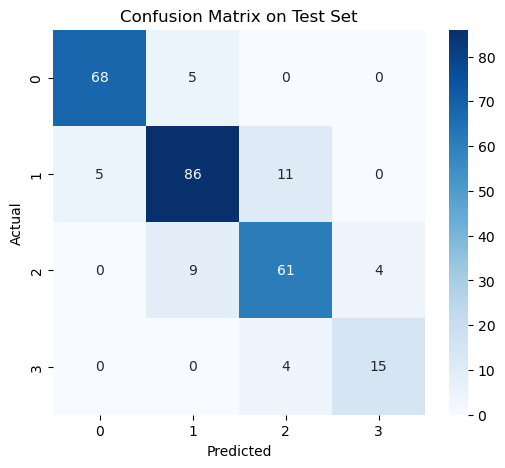

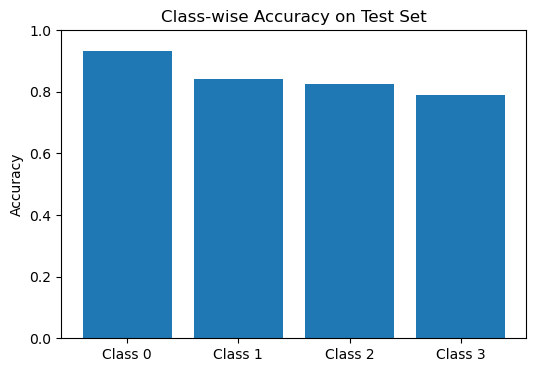

In [ ]:
# test_final_model.py
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # Import your model class
# # import sys, os
# # current_dir = os.path.dirname(os.path.abspath(__file__))
# project_root = os.path.abspath(os.path.join(current_dir, ".."))
# sys.path.append(project_root)
# from Models.models import HybridModel

# ==== Load test data ====
data = np.load("../Data/Processed/Testing_Prepared_Data/V3_test_resampled.npz")
X_test = torch.tensor(data["X"], dtype=torch.float32)
y_test = torch.tensor(data["y"], dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ==== Load trained model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(
    input_channels=19,
    cnn_channels=64,
    lstm_hidden=128,
    lstm_layers=3,
    num_classes=4
).to(device)

# Load saved weights
model.load_state_dict(torch.load("E:\ITSolera\Health_monitoring_system\Health-Monitoring\Models\Trained_models\Best_V3_model"))
model.eval()

# ==== Testing ====
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

# ==== Confusion Matrix Visualization ====
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# ==== Optional: Class-wise Accuracy Visualization ====
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6,4))
plt.bar(range(len(class_acc)), class_acc)
plt.xticks(range(len(class_acc)), [f"Class {i}" for i in range(len(class_acc))])
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy on Test Set")
plt.ylim(0,1)
plt.show()
